# Building Deep Learning Applications with Keras: DFN and CNN


## Image Classification

Suppose we have an image $\mathbf{x}$ and we want to known each of the classes $k_1 , \dots , k_n$ it belongs to. It's possible to formulate this task as a **supervised learning task**. We have a dataset $(\mathbf{x}_{1}, y_{1}), \dots ,(\mathbf{x}_{N}, y_{N})$ where $\mathbf{x}_i$ is an image and $y_i \in \{k_1 , \dots , k_n \}$. We use it to estimate the distribution $p(y \, |\,\mathbf{x})$ using a family of models $f(\mathbf{x}; \mathbf{\theta}) = p(y \,|\,\mathbf{x}; \mathbf{\theta})$.

In this notebook we restrict ourselves to two families only: **Deep Feedforward Networks (DFN)** and **Convolutional Neural Networks (CNN)**.

## A real world example: lane and road following

**Self-driving technology** is a challenging one, there is a lot of problems that falls under the "autonomous vehicle" label, and a lot of these problems are solvable by machine learning methods. One of them is the **lane and road following task**. Using image classification we want to teach a robot car to drive itself. 



In this notebook we will take a look at one simplified version of this framework: we have an small robot car equiped with a frontal camera, each time the robot sees one image it needs to take one of the three actions ($\uparrow, \leftarrow, \rightarrow$). 

<table>
<tr>
<td>
<img align="middle"   width='600' heith='100' src='images/image_classification.png'>
</td>
</tr>
</table>

The train data was collected on a circular track:

<table>
<tr>
<td>
<img align="middle" width='600' heith='100' src='images/train_track.png'>
</td>
</tr>
</table>

Since we want to check if the model can generalize to different scenarios, in this case different kinds of tracks, the test data is a set of pictures collected on a different track:

<table>
<tr>
<td>
<img align="middle" width='600' heith='100'  src='images/test_track.png'>
</td>
</tr>
</table>

To put all this into practice we have assemble a [Kaggle competition](https://www.kaggle.com/c/papis-self-driving/data). So you are welcome to try your best model in this competition. 

In [1]:
import os
import subprocess
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import optimizers
import random
from plots import plot9images, plot_confusion_matrix, plot_histogram_from_labels
from util import randomize_in_place, labels2csv
% matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The first thing we need to do is to download all the data. We are working in FloydHub, and all the data is available there. But if you want to download the data for yourself you can uncomment the cell below.

In [2]:
# if not os.path.exists("self_drive_data_papis_workshop"):
#     pro = subprocess.Popen(["bash", "download_pi_car.sh"])
#     pro.wait()

Here we will use only part of the data.

In [3]:
train_X = np.load("/self_drive_data_papis_workshop/small_train_X.npy")
train_y = np.load("/self_drive_data_papis_workshop/small_train_y.npy")
test_X = np.load("/self_drive_data_papis_workshop/small_test_X.npy")
test_y = np.load("/self_drive_data_papis_workshop/small_test_y.npy")

We can see some basic info about our data

In [4]:
command2int = {"forward": 0, "left": 1, "right": 2}
int2command = {i[1]: i[0] for i in command2int.items()}

print("data information\n")
print("- Number of training data = {}\n".format(train_X.shape[0]))
print("- Number of testing data = {}\n".format(test_X.shape[0]))
print("- Number of features = {}\n".format(test_X.shape[1]))
print("- Number of classes = {}\n".format(3))
print("- Classes:  (0 = forward, 1 = left, 2 = right)\n")

data information

- Number of training data = 10000

- Number of testing data = 1000

- Number of features = 10800

- Number of classes = 3

- Classes:  (0 = forward, 1 = left, 2 = right)



And to have a better grasp, we can directly look at some examples.

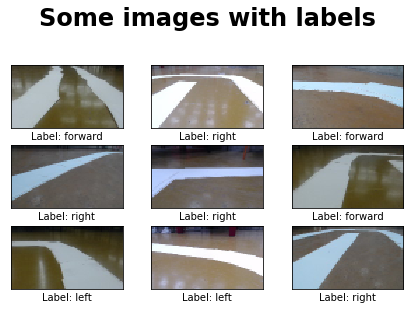

In [5]:
sample = random.sample(range(train_X.shape[0]), 9)
img9 = train_X[sample]
labels9 = train_y[sample]
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3)) 
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3))

Other important thing to do is to check if your data is **balanced**, i.e., if your data contains equal or almost equal number of samples from each class.

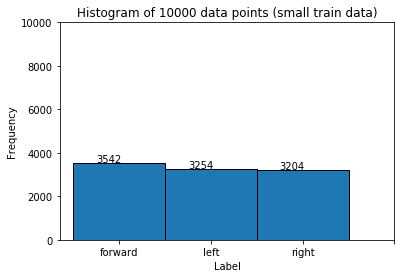

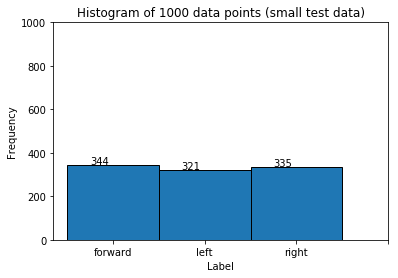

In [6]:
labels_legend = ["forward", "left", "right"]
plot_histogram_from_labels(train_y, labels_legend, "small train data")
plot_histogram_from_labels(test_y, labels_legend, "small test data")

##  Logistic regression

###  Organizing your code

One good practice is to organize your hyperparameters and models in separate classes. Here one class will have all the information that defines one implementation of the logistic regression model.


In [7]:
class LRConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 height=45,
                 width=80,
                 channels=3,
                 classes=3,
                 batch_size=32,
                 epochs=3,
                 save_step=100,
                 learning_rate=0.01,
                 momentum=0.1):
        self.height = height
        self.width = width
        self.classes = classes
        self.channels = channels
        self.batch_size = batch_size
        self.epochs = epochs
        self.save_step = save_step
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "classes = {}\n".format(self.classes)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "save_step = {}\n".format(self.save_step)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status


In [8]:
lr_config = LRConfig()
print("Hyperparams for the logistic regression model:\n")
print(lr_config)

Hyperparams for the logistic regression model:

height = 45
width = 80
channels = 3
classes = 3
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1



### Defining the logistic regression 

We can the define the logistic regression model by the equations:

<table>
<tr>
<td>
<img align="middle"  width='600' heith='100' src='images/logistic_regression.png'>
</td>
</tr>
</table>

As before we will use the class `Sequential` to define the model. 

**Hands on:** Here we want you to stack one dense layer using the `.add()` method and the `Dense` class.

In [9]:
input_dim = lr_config.height * lr_config.width * lr_config.channels

logistic_regression = keras.Sequential([Dense(units=3, input_shape=[input_dim],activation = 'softmax')])

# YOUR CODE HERE:

# END YOUR CODE

sgd = optimizers.SGD(lr=lr_config.learning_rate,
             momentum=lr_config.momentum)

logistic_regression.compile(loss='categorical_crossentropy', 
                            optimizer=sgd,
                            metrics=['accuracy'])


After a model being created we can vizualize it using the method `.summary()` 

In [10]:
print(logistic_regression.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 32403     
Total params: 32,403
Trainable params: 32,403
Non-trainable params: 0
_________________________________________________________________
None


As before, to train the model we need just to use the method `.fit()`. Here we will use the function `EarlyStopping` to stop training when the accuracy on the valid data has stopped improving.

In [11]:
train_X_float = train_X / 255.0 #normalizando

train_y_hot = np_utils.to_categorical(train_y, 3)#one hot

stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)#para quando val_acc começa aumentar

logistic_regression.fit(train_X_float, train_y_hot, batch_size=32, epochs=3,
                        validation_split=0.2, 
                        verbose=2, callbacks = [stopper])

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
 - 1s - loss: 1.8594 - acc: 0.6488 - val_loss: 2.8170 - val_acc: 0.6155
Epoch 2/3
 - 1s - loss: 1.4120 - acc: 0.6910 - val_loss: 2.1881 - val_acc: 0.6025
Epoch 3/3
 - 1s - loss: 1.4557 - acc: 0.6952 - val_loss: 2.1607 - val_acc: 0.6005


After the training we can check the model performance on the test data using the method `.evaluate()`

In [12]:
test_y_hot = np_utils.to_categorical(test_y, 3)
evaluation = logistic_regression.evaluate(test_X / 255.0, test_y_hot, verbose=1)[1]
print('\nAccuracy: {:.2f}'.format(evaluation))

1000/1000 [==============================] - 0s 59us/step

Accuracy: 0.60


When working with a classification task, one useful way to obeserve the model's performance is by using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

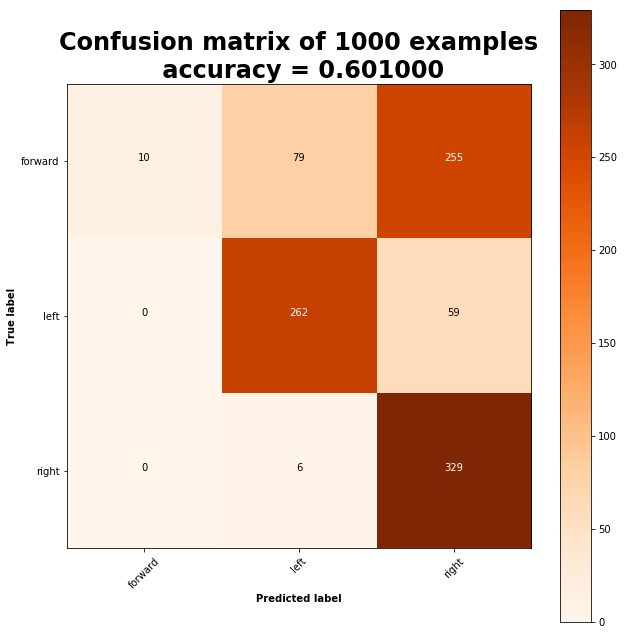

In [13]:
pred = logistic_regression.predict_classes(test_X / 255.0)
plot_confusion_matrix(truth=test_y,
                      predictions=pred,
                      save=False,
                      path="logref_confusion_matrix.png",
                      classes=["forward", "left", "right"])

We can also take a look at specific figures to see the model's behavior

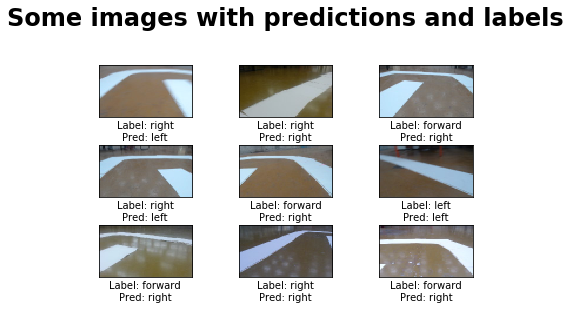

In [14]:
sample = random.sample(range(test_X.shape[0]), 9)
pred9 = pred[sample]
pred9 = [int2command[i] for i in pred9] 
img9 = test_X[sample]
labels9 = test_y[sample]
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3))
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3), pred9)

We can save the model params just by using the `.save()` method

In [15]:
logistic_regression.save("logistic_regression.h5")#salvar parâmetros

And to load the trained model we use the `.load_weights()` method

In [16]:
logistic_regression.load_weights("logistic_regression.h5")#carregando os pesos salvos
test_track_X = np.load("/self_drive_data_papis_workshop/test_track_data.npy")
pred = logistic_regression.predict_classes(test_track_X / 255.0)
labels2csv(pred, "my_first_submission.csv")

## Deep Feedforward Networks

Now that you know the basic building blocks you can define a more complex model like a **deep feedforward network**. Before defining the model, let's define a hyperparameter class. 

In [17]:
class DFNConfig(LRConfig):
    """
    Holds DFN model hyperparams.

    :param architecture: network dense architecture
    :type architecture: list of int
    :param activations: list of different activation functions
    :type actvations: list of str, None
    """
    def __init__(self, architecture=[100, 3], activations=None, input_dim=None):
        super(DFNConfig, self).__init__()
        self.architecture = architecture
        if activations is None:
            self.activations = ["relu"] * (len(architecture) - 1) +  ["softmax"]
        else:
            self.activations = activations
        if input_dim is None:
            self.input_dim = self.height * self.width * self.channels
        else:
            self.input_dim = input_dim
            

    def __str__(self):
        """
        Get all attributs values.

        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "input_dim = {}\n".format(self.input_dim)
        status += "architecture = {}\n".format(self.architecture)
        status += "activations = {}\n".format(self.activations)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "save_step = {}\n".format(self.save_step)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status


A deep model can be seen as a graph:

<table>
<tr>
<td>
<img align="middle"  width='400' heith='100'  src='images/dfn.png'>
</td>
</tr>
</table>

This graph is an alternative representation for the following set of equations:

<table>
<tr>
<td>
<img align="middle"  width='350' heith='100'  src='images/dfn_description.png'>
</td>
</tr>
</table>

$g^{(i)}$ is one activation function. Keras has a set of **activations** such as:    

- softmax
- elu
- relu
- tanh
- sigmoid
- hard_sigmoid
- linear


The net's archictecture will be given by the hyperparams `config.architecture` and `config.activations`. For example, `config.architecture = [200, 100, 3]` and `config.activations = ['relu', 'sigmoid', 'softmax']` stands for a network composed with two hidden layers one of size 200 and other of size 100 (these layers are activated by functions relu and sigmoid, respectively) and one output layer of size 3 (the output of this function is given by the softmax function). The default input size is config.height $*$ config.width $*$ config.channels, but it can be changed by the hyperparam `config.input_dim`.

**Hands on:** define the input, hidden and output layers using the `.add()` method.

In [18]:
class DFN(Sequential):
    """
    Deep Feedforward Network.
    
    The method self._modules is useful here.
    The class nn.ReLU() is useful too.

    :param config: hyper params configuration
    :type config: DFNConfig
    """
    def __init__(self, config):
        super(DFN, self).__init__()
        self.input_dim = config.input_dim
        self.architecture_size = len(config.architecture)
        self.size_arc = list(zip(config.architecture, config.activations))
        self.build_model(config)
        
    def build_model(self, config):
        for i, tuple_size in enumerate(self.size_arc):
            size, activation = tuple_size
            if i == 0:
                # YOUR CODE HERE:
                self.add(Dense(units=size, input_dim=self.input_dim,activation = activation))
                # END YOUR CODE
                
            else:
                # YOUR CODE HERE:
                self.add(Dense(units=size,activation = activation))
                # END YOUR CODE
                
        sgd = optimizers.SGD(lr=config.learning_rate,
                             momentum=config.momentum)
        self.compile(loss='categorical_crossentropy', 
                      optimizer=sgd,
                      metrics=['accuracy'])
  

Let's train some networks!

In [19]:
dfn_config1 = DFNConfig(architecture=[300, 200, 100, 3],
                       activations=["relu", "tanh", "sigmoid", "softmax"])

print("Hyperparams:\n")
print(dfn_config1)

print("Keras model:\n")


dfn1 = DFN(dfn_config1)
print(dfn1.summary())

print("Training:\n")

dfn1.fit(train_X_float, train_y_hot, batch_size=32, epochs=3,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

dfn1.save("dfn1.h5")

evaluation = dfn1.evaluate(test_X/255.0, test_y_hot, verbose=1)[1]

print('\nAccuracy: {:.2f}'.format(evaluation))

Hyperparams:

height = 45
width = 80
channels = 3
input_dim = 10800
architecture = [300, 200, 100, 3]
activations = ['relu', 'tanh', 'sigmoid', 'softmax']
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1

Keras model:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 300)               3240300   
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 3,320,903
Trainable params: 3,320,903
Non-trainable params: 0
_________________________________________________________________
None
Training:


In [22]:
dfn_config2 = DFNConfig(architecture=[500, 400, 300, 200, 100, 3])

print("Hyperparams:\n")

print(dfn_config2)

print("Keras model:\n")


dfn2 = DFN(dfn_config2)
print(dfn2.summary())

print("\nTraining:\n")

dfn2.fit(train_X_float, train_y_hot, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

dfn2.save("dfn2.h5")

evaluation = dfn2.evaluate(test_X / 255.0, test_y_hot, verbose=1)[1]

print('\nAccuracy: {:.2f}'.format(evaluation))

Hyperparams:

height = 45
width = 80
channels = 3
input_dim = 10800
architecture = [500, 400, 300, 200, 100, 3]
activations = ['relu', 'relu', 'relu', 'relu', 'relu', 'softmax']
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1

Keras model:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 500)               5400500   
_________________________________________________________________
dense_19 (Dense)             (None, 400)               200400    
_________________________________________________________________
dense_20 (Dense)             (None, 300)               120300    
_________________________________________________________________
dense_21 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
__

Using the trained model we can create a submission for the competition.

In [23]:
dfn = DFN(dfn_config2)
dfn.load_weights("dfn2.h5")
test_track_X = np.load("/self_drive_data_papis_workshop/test_track_data.npy")
pred = dfn.predict_classes(test_track_X / 255.0)
labels2csv(pred, "my_dfn_submission.csv")

## Convolutional neural network

We will define a CNN in a similar way that we have been defining the other models. As before we will define a configuration class.

In [24]:
class CNNConfig(LRConfig):
    """
    Holds CNN model hyperparams.

    :param conv_architecture: convolutional architecture
    :type conv_architecture: list of int
    :param kernel_sizes: filter sizes
    :type kernel_sizes: list of int
    :param pool_kernel: pooling filter sizes
    :type pool_kernel: list of int
    """
    def __init__(self,
                 architecture=[100, 3],
                 activations = None,
                 conv_architecture=[32, 64],
                 conv_activations = None,
                 kernel_sizes=None,
                 pool_kernel=None):
        super(CNNConfig, self).__init__()
        self.architecture = architecture
        if activations is None:
            self.activations = ["relu"] * (len(architecture) - 1) +  ["softmax"]
        else:
            self.activations = activations
        self.conv_architecture = conv_architecture
        if kernel_sizes is None:
            self.kernel_sizes = [5] * len(self.conv_architecture)
        else:
            self.kernel_sizes = kernel_sizes
        if pool_kernel is None:
            self.pool_kernel = [2] * len(self.conv_architecture)
        else:
            self.pool_kernel = pool_kernel
        if conv_activations is None:
            self.conv_activations = ["relu"] * len(self.conv_architecture)
        else:
            self.conv_activations = conv_activations
            

    def __str__(self):
        """
        Get all attributs values.

        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "architecture = {}\n".format(self.architecture)
        status += "activations = {}\n".format(self.activations)
        status += "conv_activations = {}\n".format(self.conv_activations)
        status += "conv_architecture = {}\n".format(self.conv_architecture)
        status += "kernel_sizes = {}\n".format(self.kernel_sizes)
        status += "pool_kernel = {}\n".format(self.pool_kernel)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "save_step = {}\n".format(self.save_step)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

In [25]:
cnn_config = CNNConfig()
print("Hyperparams:\n")
print(cnn_config)

Hyperparams:

height = 45
width = 80
channels = 3
architecture = [100, 3]
activations = ['relu', 'softmax']
conv_activations = ['relu', 'relu']
conv_architecture = [32, 64]
kernel_sizes = [5, 5]
pool_kernel = [2, 2]
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1



**Hands on:** define the convolutional layers using the `Conv2D` class. Remember, you must define the `input_shape` for the first convolutional layer.

In [37]:
from keras.layers import Dropout, Flatten
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D

class CNN(Sequential):
    """
    Convolutional Neural Network.
    
    The method self._modules is useful here.

    :param config: hyper params configuration
    :type config: CNNConfig
    """
    def __init__(self, config):
        super(CNN, self).__init__()
        self.conv_architecture_size = len(config.conv_architecture)
        self.architecture_size = len(config.architecture)
        self.conv_arch = list(zip(config.conv_architecture, config.kernel_sizes, config.pool_kernel, config.conv_activations))
        self.size_arc = list(zip(config.architecture, config.activations))
        self.build_model(config)
        
    def build_model(self, config):
        for i, quadruple in enumerate(self.conv_arch):
            filters, kernel_size, pool_size, activation = quadruple
            if i == 0:
                # YOUR CODE HERE:
                self.add(Conv2D(input_shape = (config.height,config.width,config.channels),
                                activation=activation,
                                filters = filters,
                                kernel_size=(kernel_size, kernel_size),
                                padding = 100))
                                               
                # END YOUR CODE
            else:
                # YOUR CODE HERE:
                 self.add(Conv2D( filters = filters,
                                 activation=activation,
                                kernel_size=(kernel_size, kernel_size),
                                padding = 100))
                # END YOUR CODE
                
            self.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
        self.add(Flatten())
        for tuple_size in self.size_arc:
            size, activation = tuple_size
            self.add(Dense(units=size, activation=activation))
        sgd = optimizers.SGD(lr=config.learning_rate,
                             momentum=config.momentum)
        self.compile(loss='categorical_crossentropy', 
                      optimizer=sgd,
                      metrics=['accuracy'])
  

Let's train some convolutional networks!

In [38]:
cnn_config1 = CNNConfig()

print("Hyperparams:\n")

print(cnn_config1)

print("Keras model:\n")


cnn1 = CNN(cnn_config1)
print(cnn1.summary())

print("\nTraining:\n")

train_X_float = train_X_float.reshape((-1, cnn_config1.height, cnn_config1.width, cnn_config1.channels))

cnn1.fit(train_X_float, train_y_hot, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

cnn1.save("cnn1.h5")

test_X = test_X.reshape((-1, cnn_config1.height, cnn_config1.width, cnn_config1.channels))


evaluation = cnn1.evaluate(test_X/255.0, test_y_hot, verbose=1)[1]

print('\nAccuracy: {:.2f}'.format(evaluation))

Hyperparams:

height = 45
width = 80
channels = 3
architecture = [100, 3]
activations = ['relu', 'softmax']
conv_activations = ['relu', 'relu']
conv_architecture = [32, 64]
kernel_sizes = [5, 5]
pool_kernel = [2, 2]
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1

Keras model:



AttributeError: 'int' object has no attribute 'lower'

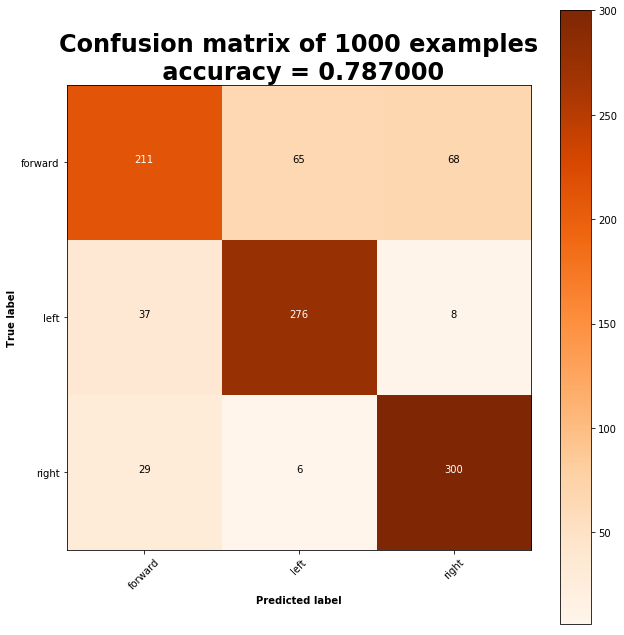

In [31]:
pred = cnn1.predict_classes(test_X / 255.0)
plot_confusion_matrix(truth=test_y,
                      predictions=pred,
                      save=False,
                      path="cnn1_confusion_matrix.png",
                      classes=["forward", "left", "right"])

In [33]:
cnn_config2 = CNNConfig(architecture=[200, 100, 3], conv_architecture = [16, 32, 32, 64])

print("Hyperparams:\n")

print(cnn_config2)

print("Keras model:\n")


cnn2 = CNN(cnn_config2)
print(cnn2.summary())

print("\nTraining:\n")

cnn2.fit(train_X_float, train_y_hot, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

cnn2.save("cnn2.h5")

evaluation = cnn2.evaluate(test_X/255.0, test_y_hot, verbose=1)[1]

print('\nAccuracy: {:.2f}'.format(evaluation))

Hyperparams:

height = 45
width = 80
channels = 3
architecture = [200, 100, 3]
activations = ['relu', 'relu', 'softmax']
conv_activations = ['relu', 'relu', 'relu', 'relu']
conv_architecture = [16, 32, 32, 64]
kernel_sizes = [5, 5, 5, 5]
pool_kernel = [2, 2, 2, 2]
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1

Keras model:



ValueError: Negative dimension size caused by subtracting 5 from 2 for 'conv2d_10/convolution' (op: 'Conv2D') with input shapes: [?,2,6,32], [5,5,32,64].

In [34]:
pred = cnn2.predict_classes(test_X / 255.0)
plot_confusion_matrix(truth=test_y,
                      predictions=pred,
                      save=False,
                      path="cnn2_confusion_matrix.png",
                      classes=["forward", "left", "right"])

NameError: name 'cnn2' is not defined

In [ ]:
cnn2 = CNN(cnn_config2)
cnn2.load_weights("cnn2.h5")
test_track_X = test_track_X.reshape((-1,
                                     cnn_config1.height,
                                     cnn_config1.width,
                                     cnn_config1.channels))
pred = cnn1.predict_classes(test_track_X / 255.0)
labels2csv(pred, "my_first_cnn_submission.csv")

### Next steps
- You can use `Dropout` to add a dropout layer to your network. Use that to change the classes defined so far.
- Use different optimizers available on Keras